In [1]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path

from transformers import EsmModel, EsmTokenizer

from variant_dataset import PATHOGENIC_VARIANTS, get_variant_sequence
from utils import (
    extract_attention, 
    plot_attention_heatmap, 
    get_attention_stats, 
    plot_attention_difference, 
    analyze_variant_attention_changes, 
    plot_variant_attention_profile,
    compare_attention_layers_difference,
    compare_attention_layers_overlay,
    analyze_layer_wise_changes,
    extract_attention_per_head,
    find_most_different_heads,
    compare_specific_heads,
)

/home/m333442/miniconda3/envs/pyg/lib/python3.12/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [2]:
# Check PyTorch & GPU
print(f"PyTorch version: {torch.__version__}")
print(f"Metal (Mac GPU) available: {torch.backends.mps.is_available()}")
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Create outputs directory
output_dir = Path("outputs")
output_dir.mkdir(exist_ok=True)
print(f"Output directory: {output_dir}")

PyTorch version: 2.4.1+cu121
Metal (Mac GPU) available: False
Using device: cpu
Output directory: outputs


In [3]:
model_name = "facebook/esm2_t33_650M_UR50D"
print(f"Loading {model_name}...")

# Load tokenizer and model with attention outputs enabled
try:
    tokenizer = EsmTokenizer.from_pretrained(model_name)
    model = EsmModel.from_pretrained(
        model_name,
        output_attentions=True,  # CRITICAL: enables attention extraction
    )
except Exception as e:
    print(f"Error loading from HF: {e}")
    print(f"Make sure you have internet connection and the model ID is correct")
    raise

model = model.to(device)
model.eval()  # Set to evaluation mode

print(f"✓ Model loaded on {device}")
print(f"Model architecture:")
print(f"  - Model size: {model_name.split('/')[-1]}")
print(f"  - Num layers: {model.config.num_hidden_layers}")
print(f"  - Num attention heads: {model.config.num_attention_heads}")
print(f"  - Hidden size: {model.config.hidden_size}")

Loading facebook/esm2_t33_650M_UR50D...


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Model loaded on cpu
Model architecture:
  - Model size: esm2_t33_650M_UR50D
  - Num layers: 33
  - Num attention heads: 20
  - Hidden size: 1280


In [4]:
# Enrich variants with sequences
variants = []
for var in PATHOGENIC_VARIANTS:
    enriched_var = var.copy()  # Don't modify original

    # Fetch sequences
    enriched_var["seq_wt"] = get_variant_sequence(var, version="wt")
    enriched_var["seq_mut"] = get_variant_sequence(var, version="mut")

    variants.append(enriched_var)
    print(f"✓ Loaded {var['gene']} {var['wt']}{var['pos']}{var['mut']}")

# Now each variant has: gene, uniprot, pos, wt, mut, seq_wt, seq_mut
# variants = pd.DataFrame(variants)

✓ Loaded HBB E7V
Deleted F at position 508
✓ Loaded CFTR F508del
✓ Loaded TP53 R175H
✓ Loaded TP53 R248W
✓ Loaded TP53 R273H


In [5]:
def analyze_variant(var):
    print(f"Analyzing: {var['gene']} {var['wt']}{var['pos']}{var['mut']}")

    # Extract attention from last layer
    wt_attn = extract_attention(
        model, tokenizer, var["seq_wt"], layer_idx=-1, device=device
    )

    mut_attn = extract_attention(
        model, tokenizer, var["seq_mut"], layer_idx=-1, device=device
    )

    print(f"WT attention shape: {wt_attn.shape}")
    print(f"Mut attention shape: {mut_attn.shape}")

    # fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # # WT attention
    # plot_attention_heatmap(
    #     wt_attn,
    #     title=f"{var['gene']} WT - {var['wt']}{var['pos']}",
    #     variant_pos=var["pos"],
    #     ax=axes[0],
    #     window=50,
    # )

    # # Mutant attention
    # plot_attention_heatmap(
    #     mut_attn,
    #     title=f"{var['gene']} Mutant - {var['mut']}{var['pos']}",
    #     variant_pos=var["pos"],
    #     ax=axes[1],
    #     window=50,
    # )

    # plt.tight_layout()
    # plt.savefig(f"outputs/{var['gene']}_comparison.png", dpi=150, bbox_inches="tight")
    # plt.show()

    # 2. Quantitative analysis
    changes = analyze_variant_attention_changes(wt_attn, mut_attn, var["pos"])
    print("\nAttention Changes:")
    for key, val in changes.items():
        print(f"{key}: {val}")

    fig, ax = plt.subplots(figsize=(8, 6))
    plot_attention_difference(
        wt_attn,
        mut_attn,
        f"{var['gene']} {var['wt']}{var['pos']}{var['mut']} - Attention Change",
        variant_pos=var["pos"],
        window=50,
        ax=ax,
    )
    plt.show()

    # wt_stats = get_attention_stats(wt_attn)
    # mut_stats = get_attention_stats(mut_attn)

    # print(f"\n{var['gene']} {var['wt']}{var['pos']}{var['mut']} Statistics:")
    # print(f"{'Metric':<20} {'WT':<15} {'Mutant':<15} {'Δ':<15}")
    # print("-" * 65)
    # for key in wt_stats.keys():
    #     delta = mut_stats[key] - wt_stats[key]
    #     print(
    #         f"{key:<20} {wt_stats[key]:<15.4f} {mut_stats[key]:<15.4f} {delta:<15.4f}"
    #     )

    # 3. Profile plots (attention vectors)
    plot_variant_attention_profile(wt_attn, mut_attn, var["pos"])
    plt.tight_layout()
    plt.show()

In [6]:
def analyze_variant(var):
    """Analyze a single variant, handling indels."""
    print(f"\n{'='*60}")
    print(f"Analyzing: {var['gene']} {var['wt']}{var['pos']}{var['mut']}")
    print(f"{'='*60}")

    # Determine variant type
    if var["mut"] == "del":
        variant_type = "deletion"
    elif var["mut"].startswith("ins"):
        variant_type = "insertion"
    else:
        variant_type = "substitution"

    # Extract attention
    wt_attn = extract_attention(
        model, tokenizer, var["seq_wt"], layer_idx=-1, device=device
    )
    mut_attn = extract_attention(
        model, tokenizer, var["seq_mut"], layer_idx=-1, device=device
    )

    print(f"Variant type: {variant_type}")
    print(f"WT shape: {wt_attn.shape}, Mut shape: {mut_attn.shape}")

    # Quantitative analysis
    changes = analyze_variant_attention_changes(
        wt_attn, mut_attn, var["pos"], variant_type=variant_type
    )

    print("\nAttention Changes:")
    for key, val in changes.items():
        print(f"  {key}: {val}")

    # For substitutions, also show difference
    fig, ax = plt.subplots(figsize=(10, 8))
    plot_attention_difference(
        wt_attn,
        mut_attn,
        f"{var['gene']} {var['wt']}{var['pos']}{var['mut']}",
        variant_pos=var["pos"],
        variant_type=variant_type,
        ax=ax,
        window=50,
    )
    plt.show()


Analyzing: HBB E7V


Variant type: substitution
WT shape: (149, 149), Mut shape: (149, 149)

Attention Changes:
  variant_pos: 7
  variant_type: substitution
  shape_mismatch: False
  attn_from_variant_change: 0.0
  attn_to_variant_change: -0.019467830657958984
  regional_attention_change: 1.7298385500907898e-05
  max_increase_pos: 1048
  max_decrease_pos: 1654
  mean_abs_change: 9.772880002856255e-05


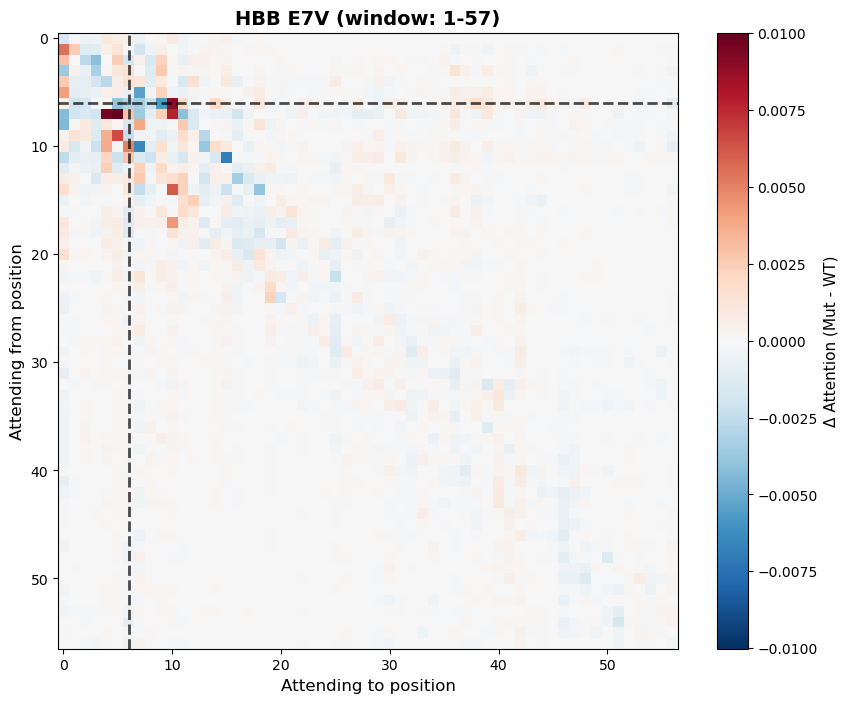

In [7]:
analyze_variant(variants[0])

In [ ]:
analyze_variant(variants[1])

In [ ]:
analyze_variant(variants[2])

In [ ]:
analyze_variant(variants[3])

In [ ]:
analyze_variant(variants[4])

In [8]:
# Extract attention from ALL layers (layer_idx=None)
var = variants[0]

wt_all_layers = extract_attention(
    model, tokenizer, var["seq_wt"], layer_idx=None, device=device  # Get all layers!
)

mut_all_layers = extract_attention(
    model, tokenizer, var["seq_mut"], layer_idx=None, device=device
)

print(f"WT attention shape: {wt_all_layers.shape}")  # [33 layers, seq_len, seq_len]
print(f"Mut attention shape: {mut_all_layers.shape}")

WT attention shape: (33, 149, 149)
Mut attention shape: (33, 149, 149)


✓ Saved to outputs/HBB_layer_differences.png


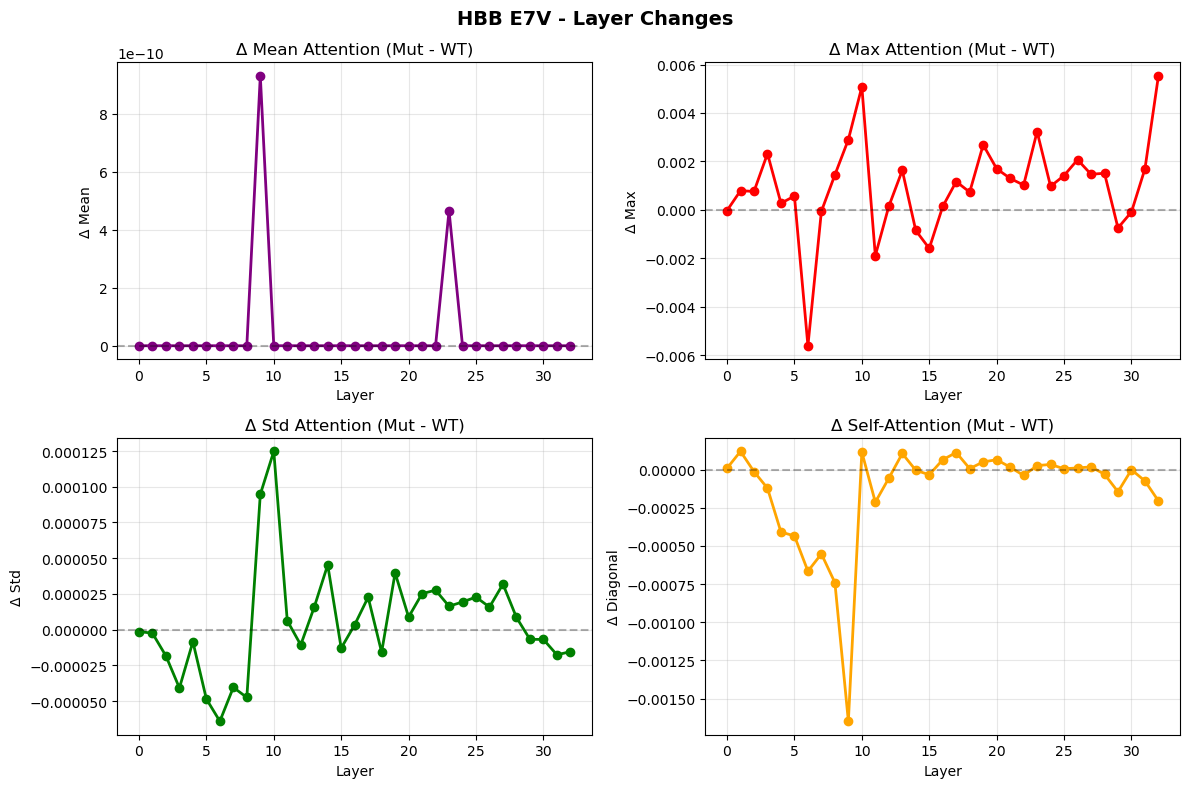

✓ Saved to outputs/HBB_layer_overlay.png


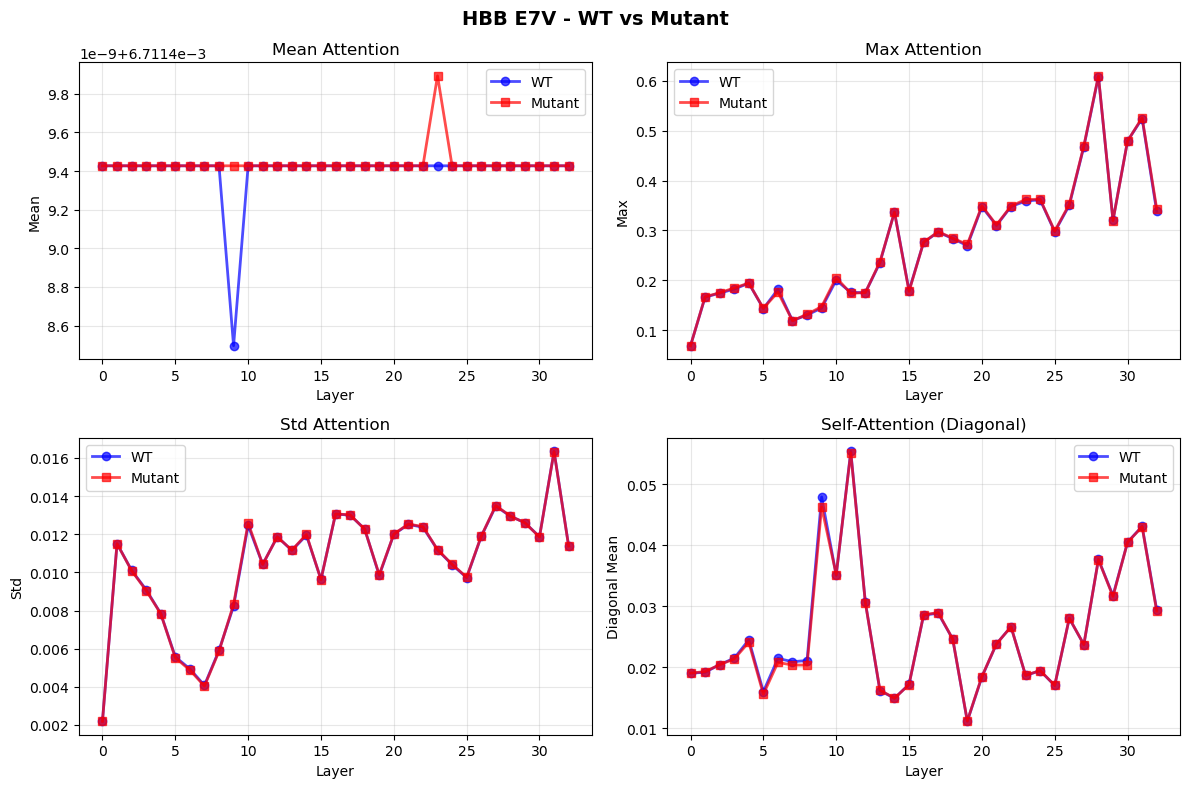


Most changed layers: [8, 9, 7, 6, 5]
Mean change across all layers: 0.000105
Layer 0: mean_abs_change=0.000015
Layer 1: mean_abs_change=0.000050
Layer 2: mean_abs_change=0.000078
Layer 3: mean_abs_change=0.000101
Layer 4: mean_abs_change=0.000179
Layer 5: mean_abs_change=0.000201
Layer 6: mean_abs_change=0.000220
Layer 7: mean_abs_change=0.000245
Layer 8: mean_abs_change=0.000274
Layer 9: mean_abs_change=0.000273


In [9]:
# 1. Difference plots (shows delta across layers)
compare_attention_layers_difference(
    wt_all_layers,
    mut_all_layers,
    title=f"{var['gene']} {var['wt']}{var['pos']}{var['mut']} - Layer Changes",
    save_path=f"outputs/{var['gene']}_layer_differences.png",
)
plt.show()

# 2. Overlay plots (direct comparison)
compare_attention_layers_overlay(
    wt_all_layers,
    mut_all_layers,
    title=f"{var['gene']} {var['wt']}{var['pos']}{var['mut']} - WT vs Mutant",
    save_path=f"outputs/{var['gene']}_layer_overlay.png",
)
plt.show()

# 3. Quantitative analysis
layer_analysis = analyze_layer_wise_changes(wt_all_layers, mut_all_layers)
print(f"\nMost changed layers: {layer_analysis['most_changed_layers']}")
print(
    f"Mean change across all layers: {layer_analysis['mean_change_across_layers']:.6f}"
)

# Look at specific layer changes
for change in layer_analysis["layer_changes"][:10]:  # First 10 layers
    print(f"Layer {change['layer']}: mean_abs_change={change['mean_abs_change']:.6f}")

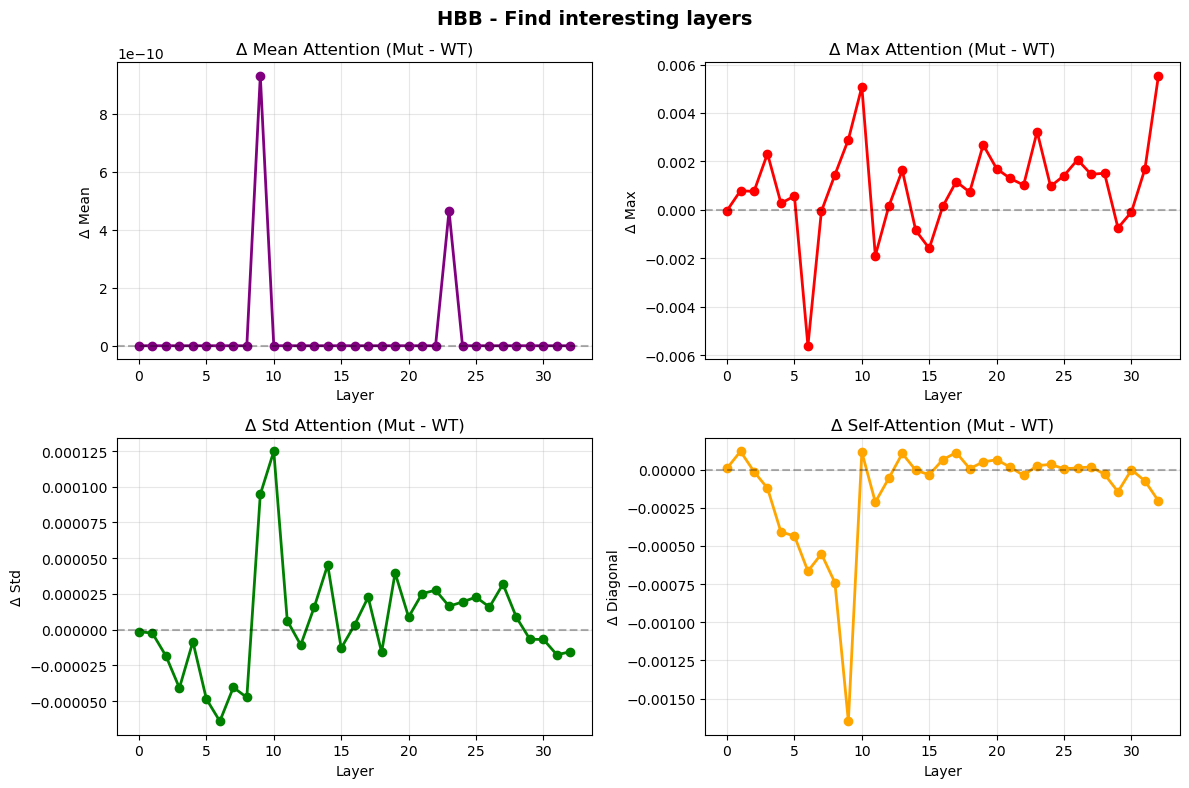

Shape per head: (20, 149, 149)

Top 3 most different heads in layer 10:
  Head 18: mean abs diff = 0.000550
  Head 1: mean abs diff = 0.000383
  Head 4: mean abs diff = 0.000330
  Head 7: mean abs diff = 0.000312
  Head 10: mean abs diff = 0.000308
  Head 13: mean abs diff = 0.000307
  Head 0: mean abs diff = 0.000297
  Head 15: mean abs diff = 0.000261
  Head 11: mean abs diff = 0.000253
  Head 2: mean abs diff = 0.000251


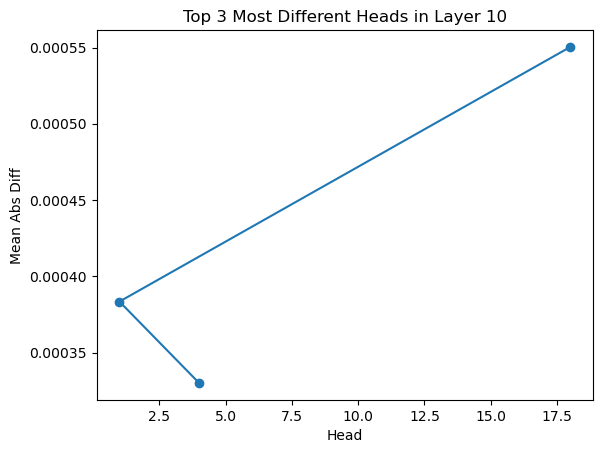

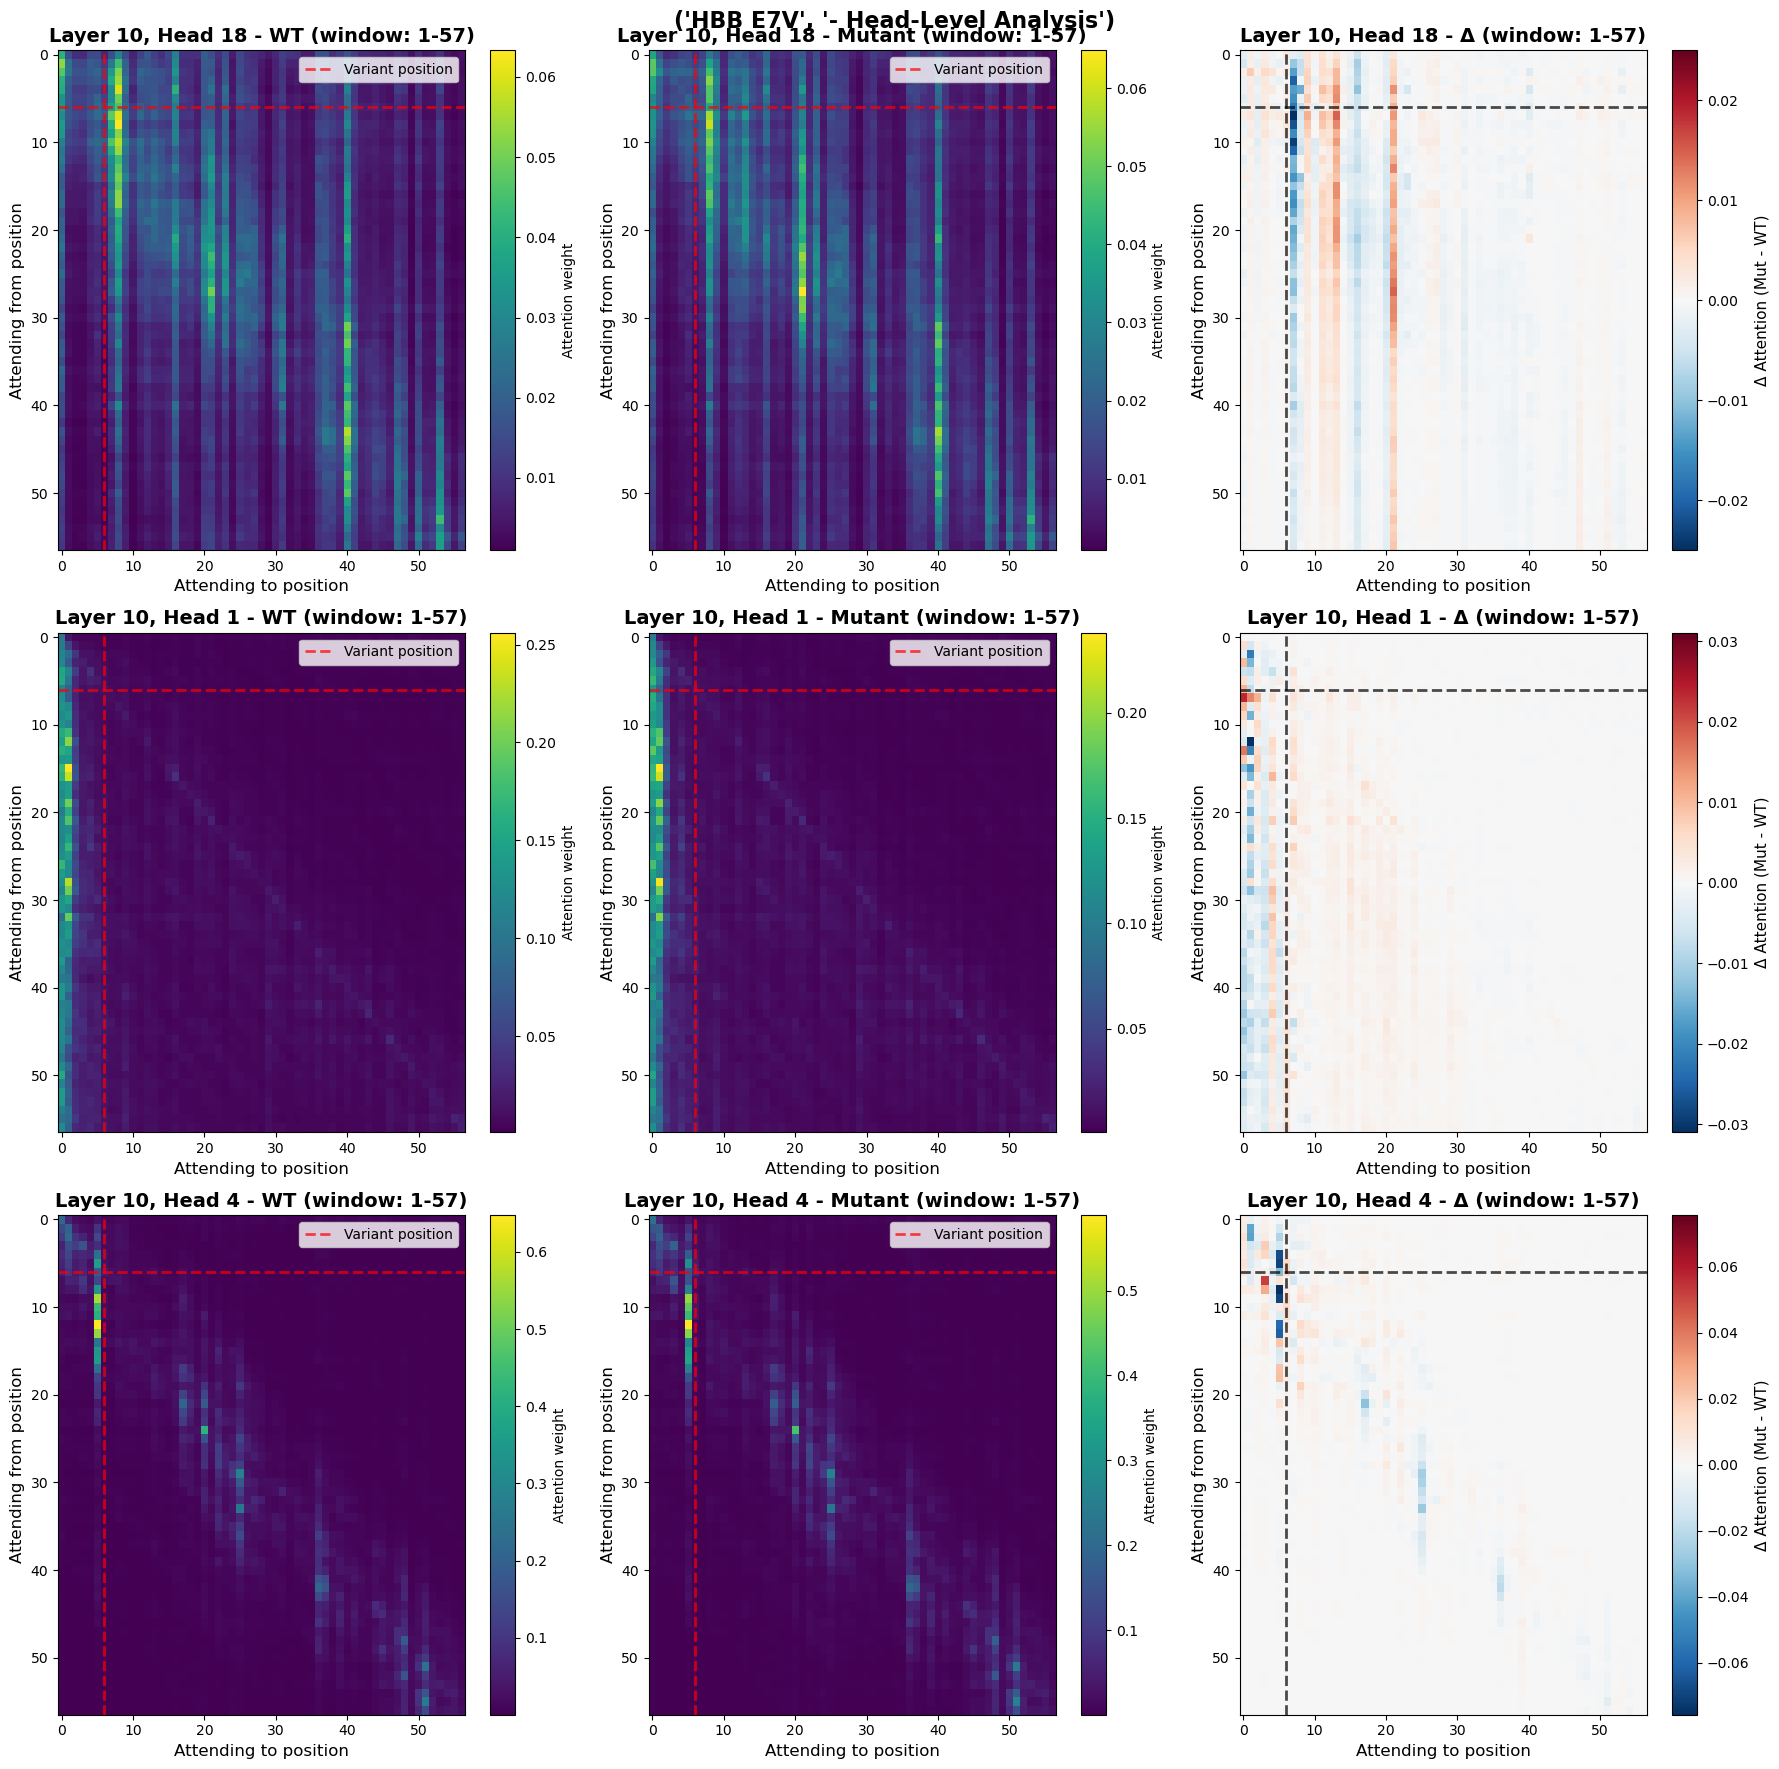

In [11]:
interesting_layer = 10
n_plot = 3


# Step 1: Start with layer averages (current approach)
wt_all_layers = extract_attention(
    model, tokenizer, var["seq_wt"], layer_idx=None, device=device
)
mut_all_layers = extract_attention(
    model, tokenizer, var["seq_mut"], layer_idx=None, device=device
)

compare_attention_layers_difference(
    wt_all_layers, mut_all_layers, title=f"{var['gene']} - Find interesting layers"
)
plt.show()


# Step 3: Extract per-head for that layer
wt_heads = extract_attention_per_head(
    model, tokenizer, var["seq_wt"], layer_idx=interesting_layer, device=device
)
mut_heads = extract_attention_per_head(
    model, tokenizer, var["seq_mut"], layer_idx=interesting_layer, device=device
)

print(f"Shape per head: {wt_heads.shape}")  # [20, seq_len, seq_len] for ESM2-650M

# Step 4: Find which heads changed most
top_heads = find_most_different_heads(wt_heads, mut_heads, top_k=10)
print(f"\nTop 3 most different heads in layer {interesting_layer}:")
for head_idx, diff in top_heads:
    print(f"  Head {head_idx}: mean abs diff = {diff:.6f}")

plt.plot(
    [h for h, _ in top_heads[:n_plot]], [d for _, d in top_heads[:n_plot]], marker="o"
)
plt.xlabel("Head")
plt.ylabel("Mean Abs Diff")
plt.title(f"Top {n_plot} Most Different Heads in Layer {interesting_layer}")
plt.show()

# Step 5: Visualize those specific heads
compare_specific_heads(
    wt_heads,
    mut_heads,
    head_indices=[h for h, _ in top_heads[:n_plot]],
    layer_idx=interesting_layer,
    variant_info=var,
    window=50,
)